In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate, linalg, optimize, sparse
import statistics
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy.polynomial
import pandas as pd

# Function definition

In [7]:
def closest(lst, K):
      
     lst = np.asarray(lst)
     idx = (np.abs(lst - K)).argmin()
     return lst[idx]
     
def closest_indx(lst, K):
      
     lst = np.asarray(lst)
     idx = (np.abs(lst - K)).argmin()
     return idx     

def counts_to_irradiance(flame_data, integration_time, k_filepath):
    
    k_data = np.loadtxt(k_filepath,skiprows=1) #
    irradiance = np.zeros(flame_data.shape)
    for i in range(len(irradiance[:,0])):
        irradiance[i,0] = flame_data[i,0]
        k_data_closest_index = np.where(k_data[:,0] == closest(k_data[:,0],flame_data[i,0]))[0]
        irradiance[i,1] = flame_data[i,1]*k_data[k_data_closest_index[0],1]/integration_time
        
    return irradiance

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

# Load data


## Load spectras

In [8]:
try:
    spectras_BS
except NameError:
    pass
else:
    del spectras_BS

try:
    spectras_RS
except NameError:
    pass
else:
    del spectras_RS
device_folder = '091410Y61'  #'0914Th7BM1'
spectras_folder = os.path.join(os.getcwd(), device_folder, 'Spectra_data')
spectras_names = sorted(os.listdir(spectras_folder))

for filename in spectras_names:
    actual_spectra = pd.read_excel(os.path.join(spectras_folder, filename), header=2)
    actual_spectra = pd.DataFrame.to_numpy(actual_spectra)
    if '_RS_' in filename:
        try:
            spectras_RS
        except NameError:
            spectras_RS = actual_spectra
        else:
            spectras_RS = np.dstack((spectras_RS, actual_spectra))

    if '_BS_' in filename:
        try:
            spectras_BS
        except NameError:
            spectras_BS = actual_spectra
        else:
            spectras_BS = np.dstack((spectras_BS, actual_spectra))

spectras_RS_total = spectras_RS[:,1,0]

ImportError: Missing optional dependency 'xlrd'. Install xlrd >= 1.0.0 for Excel support Use pip or conda to install xlrd.

In [4]:
#Here we will make some fancy things to the spectra
for i in range(len(spectras_RS[0,0,:])):
    for j in range(len(spectras_RS[:,0,0])):
        if abs(spectras_RS[j,1,i]-spectras_RS_total[j]) <= 0.05:
            spectras_RS[j,1,i] = spectras_RS_total[j]

NameError: name 'spectras_RS' is not defined

In [5]:
try:
    spectras_RS
except NameError:
    pass
else:
    fig, ax = plt.subplots(figsize=(15,7))
    for i in range(len(spectras_RS[0,0,:])):
        ax.plot(spectras_RS[:,0,i], spectras_RS[:,1,i])
    plt.show()

try:
    spectras_BS
except NameError:
    pass
else:
    fig, ax = plt.subplots(figsize=(15,7))
    for i in range(len(spectras_BS[0,0,:])):
        ax.plot(spectras_BS[:,0,i], spectras_BS[:,1,i])
    plt.show()

## Load Jsc data

In [ ]:
#device_folder = '0914Th7BM1'
try:
    excel_RS
except NameError:
    pass
else:
    del excel_RS

try:
    excel_BS
except NameError:
    pass
else:
    del excel_BS

excel_folder = os.path.join(os.getcwd(), device_folder, 'Excel_files')
excel_names = sorted(os.listdir(excel_folder))
def decimal_converter(value):
    try:
        return float(value.replace(',', '.'))
    except ValueError:
        return value
for i in range(len(excel_names)):
    for j in range(len(excel_names)):
        if spectras_names[i] in excel_names[j]:
            actual_excel = pd.DataFrame.to_numpy(pd.read_excel(os.path.join(excel_folder, excel_names[j]), header=0,converters={'Jsc (mA/cm^2)': decimal_converter, 'FF %': decimal_converter}))
            if '_RS_' in spectras_names[i]:
                try:
                    excel_RS
                except NameError:
                    excel_RS = actual_excel
                else:
                    excel_RS = np.dstack((excel_RS, actual_excel))     
                          
            if '_BS_' in spectras_names[i]:
                try:
                    excel_BS
                except NameError:
                    excel_BS = actual_excel
                else:
                    excel_BS = np.dstack((excel_BS, actual_excel))     


Error: Session cannot generate requests

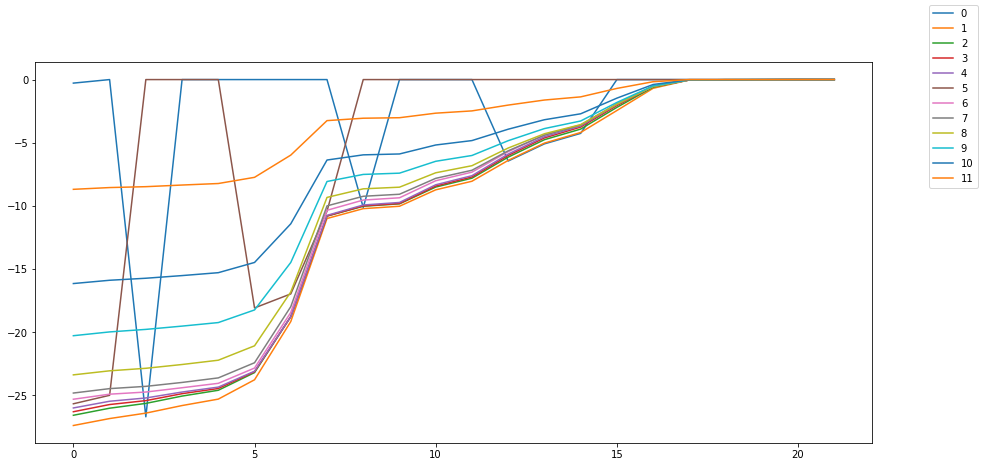

In [7]:
# Plotting
try:
    excel_RS
except NameError:
    pass
else:
    fig, ax = plt.subplots(figsize=(15,7))
    for i in range(len(excel_RS[:,0,0])):
        ax.plot(excel_RS[i,2,:], label = str(i))
    fig.legend()

try:
    excel_BS
except NameError:
    pass
else:
    fig, ax = plt.subplots(figsize=(15,7))
    for i in range(len(excel_BS[:,0,0])):
        ax.plot(excel_BS[i,2,:], label = str(i))
    fig.legend()

## Load real EQE

In [8]:
eqe_filename = 'MCV.211008.091410Y61.L.02.txt'
eqe_filepath = excel_folder = os.path.join(os.getcwd(), device_folder, 'EQEs', eqe_filename)
real_EQE = np.loadtxt(eqe_filepath, skiprows=1)
real_EQE_fit = interpolate.interp1d(real_EQE[:,0], real_EQE[:,1])

# Construct the c_matrix and Jsc

## c_matrix

In [39]:
c_matrix_wl = spectras_RS[:,0,0]
wl_interval = abs(c_matrix_wl[100]-c_matrix_wl[101])

c_matrix_RS = np.zeros((len(spectras_RS[0,0,:]), len(c_matrix_wl)))
for i in range(len(c_matrix_RS[:,0])):
    actual_FF = excel_RS[1,3,i]
    #print(actual_FF)
    for j in range(len(c_matrix_RS[0,:])):
        actual_wl = c_matrix_wl[j]
        c_matrix_RS[i,j] = spectras_RS[j,1,i] * actual_wl/ 1240 * wl_interval #actual_FF/100 

# c_matrix_BS = np.zeros((len(spectras_BS[0,0,:]), len(spectras_BS[:,0,0])))
# for i in range(len(c_matrix_BS[:,0])):
#     actual_FF = excel_BS[1,3,i]
#     for j in range(len(c_matrix_RS[0,:])):
#         actual_wl = spectras_BS[j,0,i]
#         c_matrix_BS[i,j] = spectras_BS[j,1,i] * actual_wl/1240 / wl_interval*actual_FF/100


In [40]:
#smooth the c_matrix
for i in range(len(c_matrix_RS[:,0])):
    c_matrix_RS[i,:] = smooth(c_matrix_RS[i,:],2)


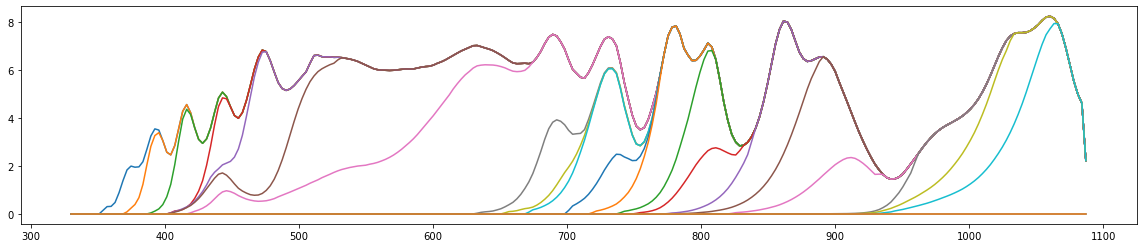

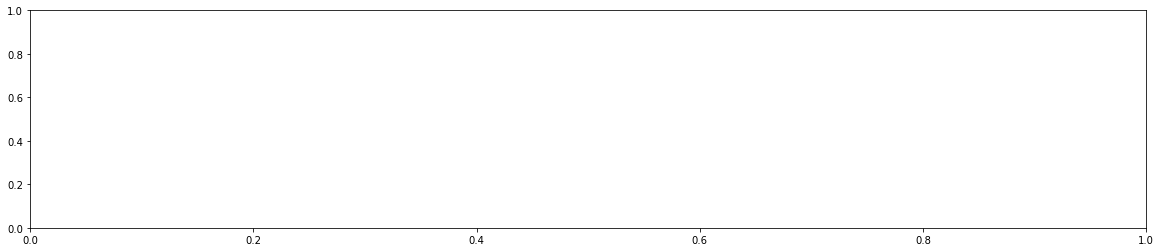

In [41]:
fig, ax = plt.subplots(figsize=(20,4))
fig, ax2 = plt.subplots(figsize =(20,4))
for i in range(len(c_matrix_RS[:,0])):
    ax.plot(c_matrix_wl, c_matrix_RS[i,:])
    #ax2.plot(c_matrix_wl, c_matrix_BS[i,:])


## Jsc

In [13]:
measure_Jsc_RS = np.array(excel_RS[1,2,:], dtype=float)
#measure_Jsc_BS = np.array(excel_BS[1,2,:], dtype = float)

# Solve the EQE

## With directrly the c_matrix and the measured Jsc

In [14]:

#print(measure_Jsc_BS.dtype)
print(c_matrix_RS.dtype)

float64


In [15]:
#spectras_BS_total = np.zeros(c_matrix_BS.shape)
spectras_RS_total = np.zeros(c_matrix_RS.shape)

for i in range(len(spectras_RS_total[:,0])):
    #spectras_BS_total = spectras_BS[:,1,-1]
    spectras_RS_total = spectras_RS[:,1,0]



[-9.40376733e+00  1.31842771e+01 -4.37424340e+00 -1.64962215e+00
  2.62379395e+00 -4.60224849e-01  4.43930994e-03 -4.86244375e-01
 -2.43696891e-01  2.62390019e+00 -5.32299702e+00  3.32400107e+00
  2.99087409e-01 -1.22733353e-01  2.54261837e-01 -2.80225915e-01
 -4.26318358e-02 -4.04825252e-02 -1.63452539e-01  5.13790710e-01
  9.15696815e-06  9.15696815e-06]
[2.739e+03 2.684e+03 2.641e+03 2.581e+03 2.530e+03 2.377e+03 1.916e+03
 1.100e+03 1.022e+03 1.003e+03 8.730e+02 8.050e+02 6.400e+02 5.030e+02
 4.190e+02 2.450e+02 6.900e+01 3.000e+00 2.000e+00 1.000e+00 0.000e+00
 0.000e+00]
[-9.75492443e+00  1.39177283e+01 -4.92933016e+00 -1.18756040e+00
  2.39138715e+00 -4.86893130e-01  8.83691451e-02 -6.13794201e-01
 -2.02554878e-01  2.64153743e+00 -5.50039794e+00  3.55430960e+00
  5.24967196e-02  1.28123005e-01  2.46080055e-01 -5.80986108e-01
  1.67467915e-01  2.68238820e-02  1.12407195e-01 -7.60943041e-02
  8.62654653e-06  8.62654653e-06]
[2.658e+03 2.602e+03 2.564e+03 2.506e+03 2.460e+03 2.320e

Text(0.5, 1.0, 'Red sweep')

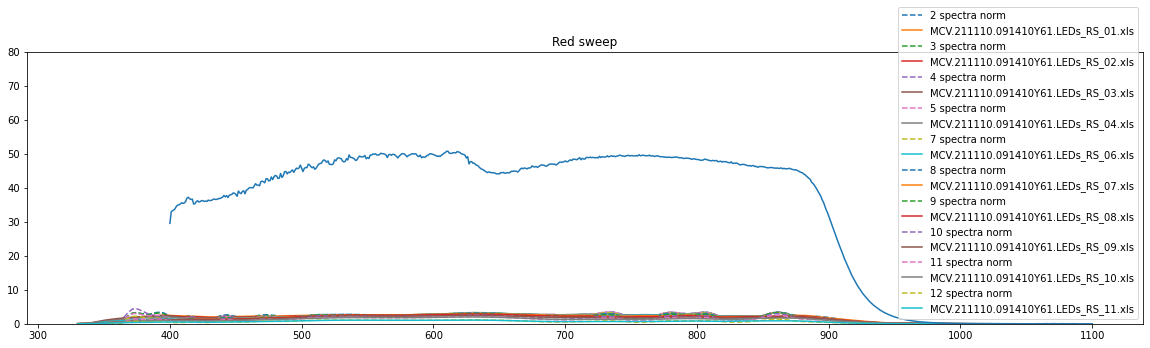

In [42]:
#solve with the red sweep
fig, ax = plt.subplots(figsize = (20,5))
#fig, ax2 = plt.subplots(figsize = (20,5))

for i in range(12):
    measure_Jsc_RS = np.array(excel_RS[i,2,:], dtype=float)
    a_fact = 100
    #measure_Jsc_RS = interpolate.UnivariateSpline(np.arange(len(excel_RS[i+1,2,:])),excel_RS[i+1,2,:], s=0.5)(np.arange(len(excel_RS[i+1,2,:])))
    EQE_linearsol = optimize.lsq_linear(c_matrix_RS, -a_fact*measure_Jsc_RS, bounds=(-50,200), lsq_solver='lsmr', tol=0.001, method='trf', max_iter=2000000)
    #EQE_linearsol, _ = optimize.nnls(c_matrix_RS, -10*measure_Jsc_RS)
    if i != 5 and i != 0:
        print(EQE_linearsol.fun)
        print(-a_fact*measure_Jsc_RS)
        ax.plot(c_matrix_wl, EQE_linearsol.x, label = str(i+1)+' spectra norm', linestyle='dashed')
        ax.plot(c_matrix_wl, smooth(EQE_linearsol.x,20), label = str(excel_names[i]))
ax.plot(real_EQE[:,0], real_EQE[:,1])

plt.ylim(0,80)
plt.legend()
plt.title('Red sweep')

# #solve with the Blue sweep
# fig, ax = plt.subplots(figsize = (20,5))
# for i in range(3):
#     measure_Jsc_BS = np.array(excel_BS[i+1,2,:], dtype=float)
#     EQE_linearsol = optimize.lsq_linear(c_matrix_BS, -100*measure_Jsc_BS, bounds=(-100,200), lsq_solver='lsmr', tol=0.001, method='trf', max_iter=2000000)
#     print(EQE_linearsol.fun)
#     print(-100*measure_Jsc_RS)
#     ax.plot(c_matrix_wl, EQE_linearsol.x, label = str(i+1))
# ax.plot(real_EQE[:,0],1*real_EQE[:,1])

# plt.legend()
# plt.title('Blue sweep')

## With the differencial between measured points

In [95]:
c_matrix_RS_diff = np.zeros(c_matrix_RS.shape)
measure_Jsc_RS_diff = np.zeros(measure_Jsc_RS.shape)
for i in range(len(c_matrix_RS_diff[:,0])-1):
    c_matrix_RS_diff[i,:] = -(c_matrix_RS[i+1,:]-c_matrix_RS[i,:])
    measure_Jsc_RS_diff[i] = measure_Jsc_RS[i+1] - measure_Jsc_RS[i]
    # for j in range(len(c_matrix_RS_diff[0,:])):
    #     if c_matrix_RS_diff[i,j]<= 0.0005:
    #         c_matrix_RS_diff[i,j] = 0


# c_matrix_BS_diff = np.zeros(c_matrix_BS.shape)
# measure_Jsc_BS_diff = np.zeros(measure_Jsc_BS.shape)
# for i in range(len(c_matrix_BS_diff[:,0])-1):
#     c_matrix_BS_diff[i,:] = c_matrix_BS[i+1,:]-c_matrix_BS[i,:]
#     measure_Jsc_BS_diff[i] = measure_Jsc_BS[i+1] - measure_Jsc_BS[i]
#     # for j in range(len(c_matrix_BS_diff[0,:])):
#     #     if c_matrix_BS_diff[i,j]<= 0.0005:
#     #         c_matrix_BS_diff[i,j] = 0




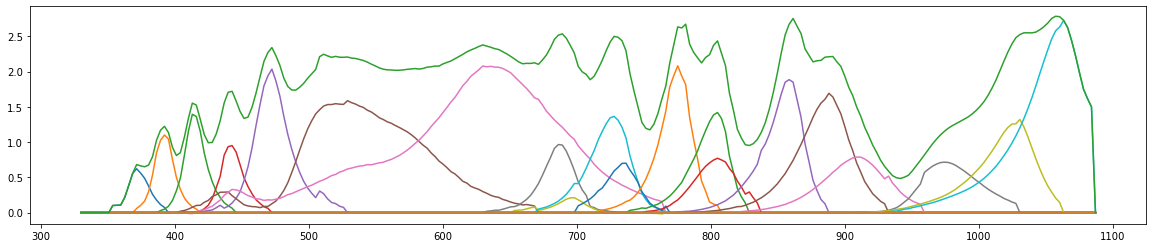

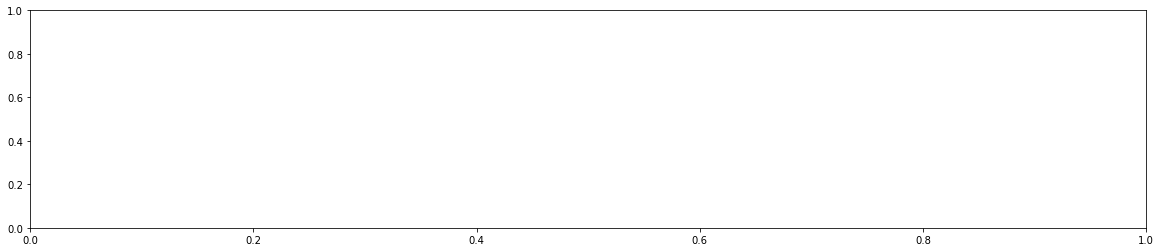

In [97]:
fig, ax = plt.subplots(figsize=(20,4))
fig, ax2 = plt.subplots(figsize =(20,4))
c_matrix_RS_summ = np.zeros(c_matrix_RS_diff[i,:].shape)
for i in range(len(c_matrix_RS[:,0])):
    ax.plot(c_matrix_wl, c_matrix_RS_diff[i,:])
    #ax2.plot(c_matrix_wl, c_matrix_BS_diff[i,:])
    c_matrix_RS_summ = c_matrix_RS_summ + c_matrix_RS_diff[i,:]
ax.plot(c_matrix_wl, c_matrix_RS_summ)

<ipython-input-72-3e4b203d9bc4>:6: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(c_matrix_wl, EQE_linearsol.x/spectras_BS[:,1,-1], label = str(i+1))
<ipython-input-72-3e4b203d9bc4>:7: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(c_matrix_wl, smooth(EQE_linearsol.x/spectras_BS[:,1,-1],20), label = str(i+1))
<ipython-input-72-3e4b203d9bc4>:6: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(c_matrix_wl, EQE_linearsol.x/spectras_BS[:,1,-1], label = str(i+1))
<ipython-input-72-3e4b203d9bc4>:7: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(c_matrix_wl, smooth(EQE_linearsol.x/spectras_BS[:,1,-1],20), label = str(i+1))
<ipython-input-72-3e4b203d9bc4>:6: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(c_matrix_wl, EQE_linearsol.x/spectras_BS[:,1,-1], label = str(i+1))
<ipython-input-72-3e4b203d9bc4>:7: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(c_matrix_wl, smooth(EQE_li

Text(0.5, 1.0, 'Blue sweep')

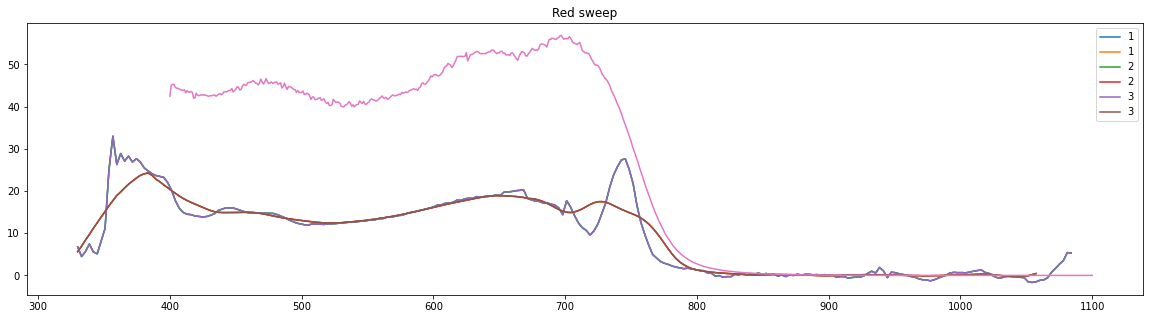

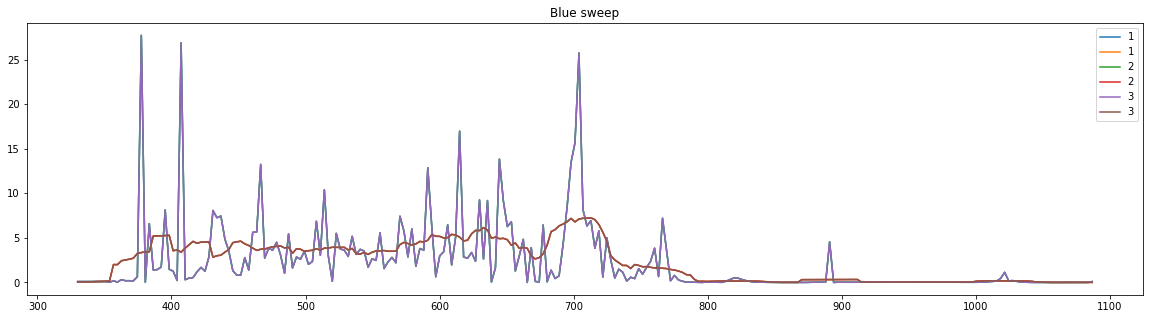

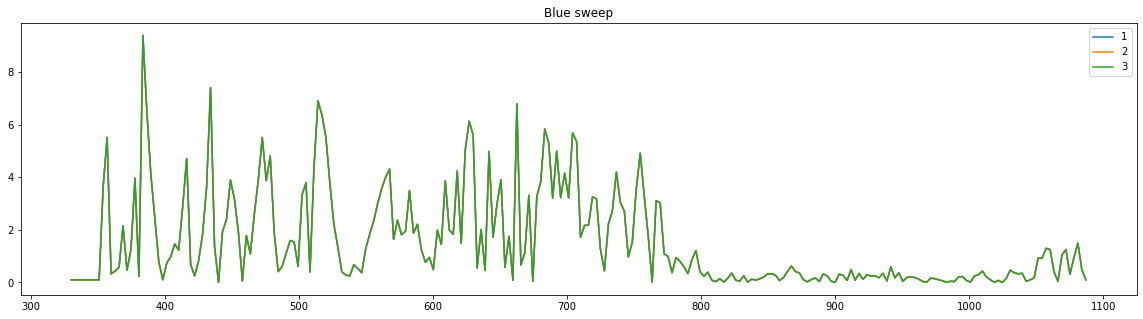

In [72]:
#solve with the red sweep
fig, ax = plt.subplots(figsize = (20,5))
for i in range(3):
    measure_Jsc_RS = np.array(excel_RS[i+1,2,:], dtype=float)
    EQE_linearsol = optimize.lsq_linear(c_matrix_RS_diff, 55*measure_Jsc_RS_diff, bounds=(-100,200), lsq_solver='lsmr', tol=0.00001, method='trf', max_iter=2000000)
    ax.plot(c_matrix_wl, EQE_linearsol.x/spectras_BS[:,1,-1], label = str(i+1))
    ax.plot(c_matrix_wl, smooth(EQE_linearsol.x/spectras_BS[:,1,-1],20), label = str(i+1))
ax.plot(real_EQE[:,0],1*real_EQE[:,1])


plt.legend()
plt.title('Red sweep')

#solve with the Blue sweep
fig, ax = plt.subplots(figsize = (20,5))
for i in range(3):
    measure_Jsc_BS = np.array(excel_BS[i+1,2,:], dtype=float)
    EQE_linearsol = optimize.lsq_linear(c_matrix_BS_diff, -3.5*measure_Jsc_BS_diff, bounds=(0,100), lsq_solver='lsmr', tol=0.001, method='trf', max_iter=2000000)
    ax.plot(c_matrix_wl, EQE_linearsol.x, label = str(i+1))
    ax.plot(c_matrix_wl, smooth(EQE_linearsol.x,15), label = str(i+1))

plt.legend()
plt.title('Blue sweep')

#solve with both sweeps
fig, ax = plt.subplots(figsize = (20,5))
for i in range(3):
    measure_Jsc_BS = np.array(excel_BS[i+1,2,:], dtype=float)
    EQE_linearsol = optimize.lsq_linear(np.vstack((c_matrix_BS_diff, c_matrix_RS_diff)), 5*np.hstack((-measure_Jsc_BS_diff,measure_Jsc_RS_diff)), bounds=(0,100), lsq_solver='lsmr', tol=0.001, method='trf', max_iter=2000000)
    ax.plot(c_matrix_wl, EQE_linearsol.x, label = str(i+1))

plt.legend()
plt.title('Blue sweep')
